<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARIMA-14.09.2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [94]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

stock = "PGSUS.IS"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14")

df_close = stock_data['Close']
df_log = np.log(df_close)
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

best_order = model_autoARIMA.order
print("Best ARIMA Order:", best_order)

[*********************100%%**********************]  1 of 1 completed
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10009.585, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10019.411, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10018.114, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10009.484, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10025.896, Time=0.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10024.156, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10024.160, Time=1.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10025.444, Time=1.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10022.167, Time=1.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10026.288, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10019.594, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-10024.583, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-10024.598, Time=0.33 sec
 ARI

In [95]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

start="2023-06-05"
end="2023-08-07"

stock_data = yf.download(stock, start=start, end=end, progress=False)
new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)
model = ARIMA(np.log(stock_data["Close"]), order=best_order)
fitted = model.fit()

print(len(stock_data))

42


In [ ]:
forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=stock_data.index)
lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T
# upper_series = pd.Series(stock_data.index, conf.iloc[:, 1])

plt.figure(figsize=(16,6), dpi=100)
# plt.plot(np.exp(train_data[3500:]), label='Training data', color="black")
plt.plot(np.exp(test_data[100:]), color='black', label='Test data')

# plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
# plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
#                  color='k', alpha=.10)


from datetime import datetime, timedelta
today = datetime.now()
tomorrow = today + timedelta(days=1)
formatted_date = tomorrow.strftime("%Y-%m-%d")
today = today.strftime("%Y-%m-%d")

stock_data = yf.download(stock, start=end, end=formatted_date, progress=False)
plt.plot(stock_data.index, stock_data["Close"], color='red', label='Excluded stock data')

plt.plot(new_date_index, np.exp(fc), color='blue', label='Predicted stock price')  # Convert back to original scale
plt.fill_between(new_date_index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

print("FİYAT: ", round(stock_data["Close"].iloc[-1], 2), "TL\n")

print("ÜST PROJEKSİYON: ", round(np.exp(conf.iloc[:, 1].max()), 2), "TL")
print("ALT PROJEKSİYON: ", round(np.exp(conf.iloc[:, 0].min()), 2), "TL\n")

print("Günlük AL noktası: ", round(np.exp(float(lower_series[1][lower_series[0] == pd.Timestamp(today)])), 2), "TL")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

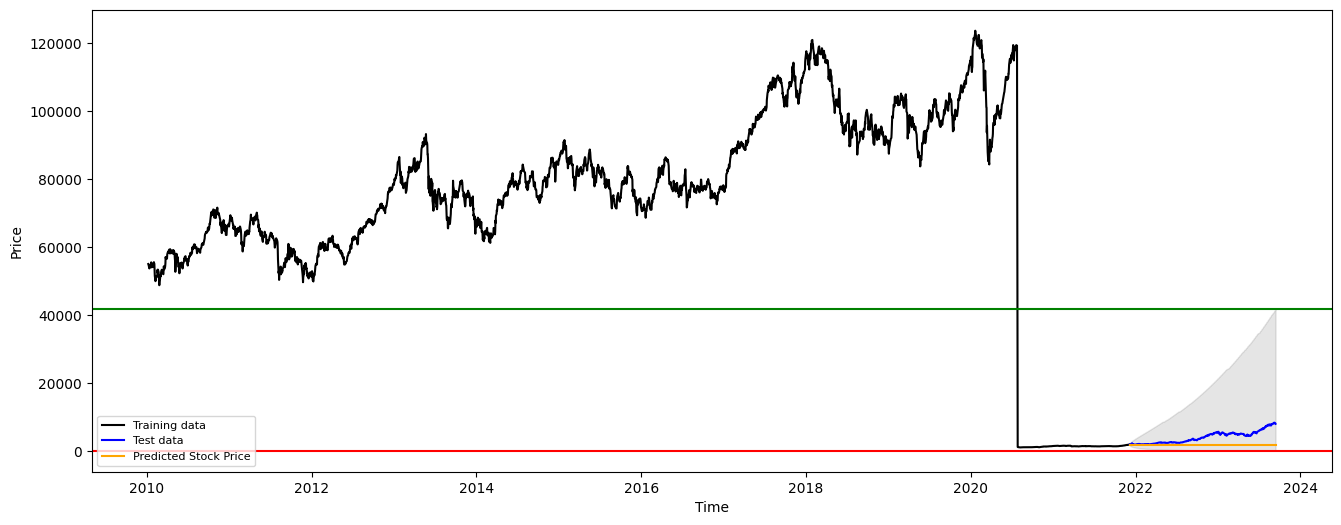

In [90]:
model = ARIMA(train_data, order=best_order)
fitted = model.fit()

forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(train_data[1000:]), label='Training data', color="black")
plt.plot(np.exp(test_data), color='blue', label='Test data')

plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [27]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.2674679937215887
MAE: 0.4483644851402625
RMSE: 0.5171730790766169
MAPE: 0.08581938413187133


In [51]:
import requests
from bs4 import BeautifulSoup

market = []

url = f"https://tr.tradingview.com/symbols/BIST-XU100/components/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all(class_="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat")

  for element in elements:
    text = element.get_text()
    market.append(text)

for stock in market:
  try:
    print(stock)
    stock = stock+".IS"
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14", progress=False)

    df_close = stock_data['Close']
    df_log = np.log(df_close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

    best_order = model_autoARIMA.order

    print("Best param search is done. \n")
    # print("Best ARIMA Order:", best_order)

    start="2023-08-28"
    end="2023-09-11"

    stock_data = yf.download(stock, start=start, end=end, progress=False)
    new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)
    model = ARIMA(np.log(stock_data["Close"]), order=best_order)
    fitted = model.fit()

    # print(len(stock_data))

    forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

    fc = forecast_results.predicted_mean
    conf = forecast_results.conf_int()

    fc_series = pd.Series(fc, index=stock_data.index)
    lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T

    from datetime import datetime, timedelta
    today = datetime.now()
    tomorrow = today + timedelta(days=1)
    formatted_date = tomorrow.strftime("%Y-%m-%d")
    today = today.strftime("%Y-%m-%d")

    stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14", progress=False)

    if round(stock_data["Close"].iloc[-1], 2) < round(np.exp(float(lower_series[1][lower_series[0] == pd.Timestamp(today)])), 2):
      print("****************",stock,"****************", "\n")
  except:
    print("Error with this stock.\n")

AEFES
Best param search is done. 

AGHOL
Best param search is done. 

AHGAZ
Best param search is done. 

AKBNK
Best param search is done. 

**************** AKBNK.IS **************** 

AKCNS
Best param search is done. 

AKFGY
Best param search is done. 

AKSA
Best param search is done. 

AKSEN
Best param search is done. 

ALARK
Best param search is done. 

ALBRK
Best param search is done. 



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALFAS.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


**************** ALBRK.IS **************** 

ALFAS
Error with this stock.

ARCLK
Best param search is done. 

ASELS
Best param search is done. 

ASTOR


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASTOR.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

ASUZU
Best param search is done. 

AYDEM
Best param search is done. 

BAGFS
Best param search is done. 

BERA
Best param search is done. 

BIMAS
Best param search is done. 

BIOEN


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BIOEN.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

BRSAN
Best param search is done. 

BRYAT
Best param search is done. 

BUCIM
Best param search is done. 

CANTE
Best param search is done. 

CCOLA
Best param search is done. 

CEMTS
Best param search is done. 

CIMSA
Best param search is done. 

DOAS
Best param search is done. 

DOHOL
Best param search is done. 

**************** DOHOL.IS **************** 

ECILC
Best param search is done. 

ECZYT
Best param search is done. 

EGEEN
Best param search is done. 

EKGYO
Best param search is done. 

**************** EKGYO.IS **************** 

ENJSA
Best param search is done. 

ENKAI
Best param search is done. 

EREGL
Best param search is done. 

**************** EREGL.IS **************** 

EUREN


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EUREN.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

FROTO
Best param search is done. 

GARAN
Best param search is done. 

**************** GARAN.IS **************** 

GENIL
Best param search is done. 

GESAN
Best param search is done. 

GLYHO
Best param search is done. 

GSDHO
Best param search is done. 

**************** GSDHO.IS **************** 

GUBRF
Best param search is done. 

GWIND
Best param search is done. 

HALKB
Best param search is done. 

HEKTS
Best param search is done. 

IPEKE
Best param search is done. 

ISCTR
Best param search is done. 

ISDMR
Best param search is done. 

**************** ISDMR.IS **************** 

ISGYO
Best param search is done. 

ISMEN
Best param search is done. 

IZMDC
Best param search is done. 

**************** IZMDC.IS **************** 

KARSN
Best param search is done. 

KCAER


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KCAER.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

KCHOL
Best param search is done. 

**************** KCHOL.IS **************** 

KMPUR
Best param search is done. 

KONTR
Best param search is done. 

KONYA
Best param search is done. 

KORDS
Best param search is done. 

KOZAA
Best param search is done. 

KOZAL
Best param search is done. 

KRDMD
Best param search is done. 

KZBGY
Best param search is done. 

**************** KZBGY.IS **************** 

MAVI
Best param search is done. 

MGROS
Best param search is done. 

ODAS
Best param search is done. 

**************** ODAS.IS **************** 

OTKAR
Best param search is done. 

**************** OTKAR.IS **************** 

OYAKC
Best param search is done. 

PENTA
Best param search is done. 

PETKM
Best param search is done. 

**************** PETKM.IS **************** 

PGSUS
Best param search is done. 

PSGYO


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PSGYO.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

QUAGR
Best param search is done. 

**************** QUAGR.IS **************** 

SAHOL
Best param search is done. 

**************** SAHOL.IS **************** 

SASA
Best param search is done. 

**************** SASA.IS **************** 

SELEC
Best param search is done. 

**************** SELEC.IS **************** 

SISE
Best param search is done. 

SKBNK
Best param search is done. 

SMRTG
Best param search is done. 

SNGYO
Best param search is done. 

SOKM
Best param search is done. 

TAVHL
Best param search is done. 

**************** TAVHL.IS **************** 

TCELL
Best param search is done. 

THYAO
Best param search is done. 

**************** THYAO.IS **************** 

TKFEN
Best param search is done. 

TKNSA
Best param search is done. 

**************** TKNSA.IS **************** 

TOASO
Best param search is done. 

TSKB
Best param search is done. 

**************** TSKB.IS **************** 

TTKOM
Best param search is done. 

**************** TTKOM.IS *